### Gap Junction API

In [ ]:
from unet import *
from pathlib import Path
import re
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score, confusion_matrix

In [27]:
#Important Paths
model_dir = "/mnt/d/mishaal_to_move/2d_gd_mem_run1/model5_epoch149.pk1" #Model
output_dir = "/home/tommytang111/results" #Output
dataset_dir = "/mnt/e/Mishaal/sem_dauer_2/jnc_only_dataset_test" #Data

#Data and Labels (sorted because naming convention is typically dataset, section, coordinates. Example: SEM_Dauer_2_image_export_s000 -> 001)
imgs = [i for i in sorted(os.listdir(Path(dataset_dir) / "imgs"))] 
labels = [i for i in sorted(os.listdir(Path(dataset_dir) / "gts"))]

#### Load model

In [21]:
model = joblib.load(model_dir)
model = model.to("cuda") #Send to gpu
model.eval() #Set evaluation mode

UNet(
  (down_conv1): DownBlock(
    (double_conv): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down_sample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_conv2): DownBlock(
    (double_conv): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      

#### Load data

In [25]:
#Create TestDataset class (Note:There are other dataset types in datasets.py). This defines how images/data is read from disk.
dataset = TestDataset(dataset_dir, td=False, membrane=False)
#Load dataset class in Dataloader
dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=8)

#### Inference

In [26]:
"""
Generates gap junction prediction masks for each batch, converting each tensor into a numpy array with cpu as uint8. 
Keeps track of the image number while going through batches, assuming the data is sorted by alphabetically ascending 
order when read from disk. 
"""

img_num = 0 #References which image is being refered to in imgs:List

with torch.no_grad(): 
    for batch in tqdm(dataloader):
        image = batch[0].to("cuda")
        batch_pred = model(image)
        for i in range(batch_pred.shape[0]): #For each image in the batch
            #Convert tensor to binary mask using Sigmoid activation first
            gj_pred = (nn.Sigmoid()(batch_pred[i]) >= 0.5)
            gj_pred = gj_pred.squeeze(0).detach().cpu().numpy().astype("uint8")
            save_name = Path(output_dir) / re.sub(r'.png.png$', r'_pred.png.png', imgs[img_num])
            cv2.imwrite(save_name, gj_pred * 255) #All values either black:0 or white:255
            img_num += 1

100%|██████████| 169/169 [01:13<00:00,  2.29it/s]


#### Visualize Results

Text(0.5, 1.0, 'Overlay')

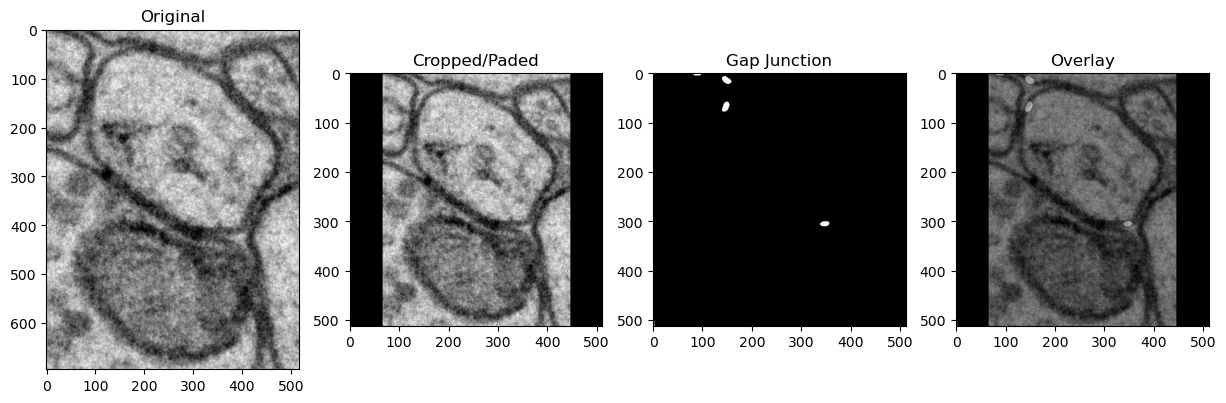

In [9]:
#Test a random image from the dataset
random_path = random.choice(imgs)
random_img = Path(dataset_dir) / random_path
random_resized_img = np.array(resize_image(str(random_img), 512, 512, (0,0,0)))
random_pred = cv2.imread(str(Path(output_dir) / re.sub(r'.png$', r'_pred.png', str(random_path))), cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(1,4, figsize=(15,5))
ax[0].imshow(cv2.imread(random_img, cv2.IMREAD_GRAYSCALE), cmap="gray")
ax[0].set_title('Original')
ax[1].imshow(random_resized_img, cmap="gray")
ax[1].set_title('Cropped/Paded')
ax[2].imshow(random_pred, cmap="gray")
ax[2].set_title('Gap Junction')
ax[3].imshow(random_resized_img, cmap="gray")
ax[3].imshow(random_pred, cmap="gray", alpha=0.4)
ax[3].set_title('Overlay')

#### Post-Inference Evaluation

In [ ]:
#Create results dictionary
results = {'accuracy': [],
           'precision': [],
           'recall': [],
           'f1': [],
           'iou': [],
           'dice': []
}

In [40]:
#We have a list of all the input image file names in imgs
for img in tqdm(imgs):
    #Load Predictions
    gj_pred = Path(output_dir) / re.sub(r'.png.png$', r'_pred.png.png', img)
    gj_pred = cv2.imread(gj_pred, cv2.IMREAD_GRAYSCALE)

    #Load Labels
    label = Path(dataset_dir) / 'gts' / re.sub(r'.png.png$', r'_label.png.png' ,img)
    label = cv2.imread(label, cv2.IMREAD_GRAYSCALE)
    
    #Ensure same dimensions
    if gj_pred.shape != label.shape:
        gj_pred = cv2.resize(gj_pred, (gj_pred.shape[1], gj_pred.shape[0]))
        
    #Binarize masks (0 or 1)
    gj_pred_binary = (gj_pred > 127).astype(np.uint8)
    label_binary = (label > 128).astype(np.uint8)
    
    #Flatten masks for metric calculations
    gj_pred_flat = gj_pred_binary.flatten()
    label_flat = label_binary.flatten()
    
    #Calculate metrics
    results['accuracy'].append(accuracy_score(gj_pred_flat, label_flat))
    results['precision'].append(precision_score(gj_pred_flat, label_flat, zero_division=0))
    results['recall'].append(recall_score(gj_pred_flat, label_flat, zero_division=0))
    results['f1'].append(f1_score(gj_pred_flat, label_flat, zero_division=0))
    results['iou'].append(jaccard_score(gj_pred_flat, label_flat, zero_division=0))
    
    #Calculate Dice Manually
    intersection = np.logical_and(gj_pred_binary, label_binary).sum()
    dice = (2.0 * intersection) / (gj_pred_binary.sum() + label_binary.sum() + 1e-10)
    results['dice'].append(dice)
    
    

100%|██████████| 2695/2695 [03:17<00:00, 13.63it/s]


In [ ]:
#Calculate averages
for key in results:
    results[key] = np.mean(results[key])
    
plt.figure(figsize=(10,6))

{'accuracy': np.float64(0.9969344586410211),
 'precision': np.float64(0.8414373665583991),
 'recall': np.float64(0.7974802584526051),
 'f1': np.float64(0.8109536166852945),
 'iou': np.float64(0.7133944942509844),
 'dice': np.float64(0.8109325867240186)}

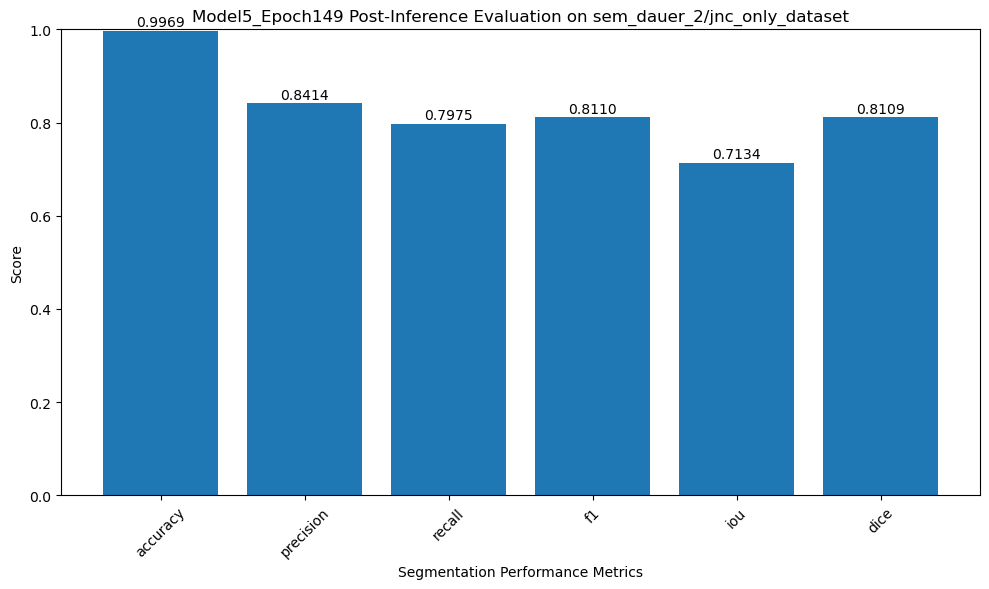

In [45]:
#Plot bar chart of evaluation results
plt.figure(figsize=(10,6))
plt.title('Model5_Epoch149 Post-Inference Evaluation on sem_dauer_2/jnc_only_dataset')
plt.bar(results.keys(), results.values())
plt.ylim(0,1)
plt.xlabel('Segmentation Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
for i, v in enumerate(results.values()):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()


#### Miscellaneous

In [ ]:
#Renaming label files to match the image file convention
#Original name = sem2dauer_gj_2d_training.vsseg_export_s000_Y4_X5.png.png
#Target name = SEM_dauer_2_image_export_s000_Y4_X5_label.png.png

!rename 's/^(sem2dauer_gj_2d_training.vsseg_export_\w+)\.png\.png$/SEM_dauer_2_image_export_$1_label.png.png/' sem2dauer_gj_2d_training.vsseg_export_*.png.png
